In [13]:
# from google.colab import drive
# drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import numpy as np
import math
import networkx as nx
import timeit
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from numpy import sin, cos
from scipy.integrate import odeint
from itertools import repeat

In [0]:
m1 = 4      #kg
m2 = 1      #kg
l1 = 1    #m
l2 = 1    #m
g = 10     #Nm/s
a = m1*l1**2+m2*l1**2
b = m2*l2**2
c = m2*l1*l2
d = g*m1*l1+g*m2*l1
e = g*m2*l2
def dynamic_model(x,t,u):
    #input:     state x: (4,) vector (theta1,theta2,omega1,omega2)
    #           control input u: scalar
    #output:    new state x: (4,) vector
    x = np.array(x)
    theta1 = x[0]
    theta2 = x[1]
    omega1 = x[2]
    omega2 = x[3]
    omega12 = x[2:].reshape(-1,1)
    M = np.array([[a+b+2*c*math.cos(theta2),b+c*math.cos(theta2)],[b+c*math.cos(theta2),b]])
    C = np.array([[-c*math.sin(theta2)*omega2,-c*math.sin(theta2)*(omega1+omega2)],[c*math.sin(theta2)*omega1,0]])
    G = np.array([-d*math.sin(theta1)-e*math.sin(theta1+theta2),-e*math.sin(theta1+theta2)]).reshape(-1,1)
    f2 = -np.linalg.inv(M)@(C@omega12+G)
    f = np.vstack((omega12,f2))
    g2 = np.linalg.inv(M)@np.array([0,1]).reshape(-1,1)
    g = np.vstack((np.array([[0],[0]]),g2))
    x_dot = (f+g*u).reshape(-1)
    return x_dot

In [0]:
d_theta = math.pi/40        #overall, 80 states for theta1/theta2
d_omega = 10/50             #overall, 50 states for omega1/omega2
x_bound = np.array([0,0,-5,-5])
discretization = np.array([d_theta,d_theta,d_omega,d_omega])
def discretize(x):
    #input:     (state x(tuple), u, dt)
    #           
    #output:    (discretized state(tuple), u, dt)
    if type(x[0])==tuple:
        dt = x[2]
        u = x[1]
        x = np.array(x[0]) 
    else:
        dt = 0
        u = 0
        x = np.array(x) 
    x_adj = (x - x_bound)/discretization
    x_dis = np.round(x_adj, 0).astype(int)
    x_dis = tuple(x_dis)
    return (x_dis,u,dt)
def un_discretize(x_dis):
    #input:     (4,) array or tuple
    #output:    the average value of this cell, tuple
    x_dis = np.array(x_dis)
    return tuple(x_dis*discretization+x_bound)

In [0]:
# consider only the subspace of the original 100^4 state-space and change the discretization if necessary
Theta1_1 = np.linspace(0,1/2*math.pi,20)
Theta1_2 = np.linspace(9/5*math.pi,2*math.pi,8)
Theta1 = np.hstack((Theta1_1,Theta1_2))
# Theta1 = list(np.linspace(-1/5*math.pi,1/2*math.pi,28))
Theta2_1 = np.linspace(0,1/4*math.pi,10)
Theta2_2 = np.linspace(7/4*math.pi,2*math.pi,10)
Theta2 = np.hstack((Theta2_1,Theta2_2))
# Theta2 = np.linspace(-1/4*math.pi,1/4*math.pi,20)
Omega1 = np.linspace(-5,1,30)
Omega2 = np.linspace(-3,3,30)
# sub-state-space
state_space = [(i,j,k,m) for i in Theta1 for j in Theta2 for k in Omega1 for m in Omega2]
# state_space = list(map(wrap,state_space))
state_space_dis = list(map(discretize,state_space))

In [0]:
# odeint is too slow, use alternative:
def rk4(derivs, y0, t, *args, **kwargs):
    """
    Integrate 1D or ND system of ODEs using 4-th order Runge-Kutta.
    *y0* initial state vector
    *t* sample times
    *derivs* returns the derivative of the system and has the signature ``dy = derivs(yi, ti)``
    *args* additional arguments passed to the derivative function
    *kwargs* additional keyword arguments passed to the derivative function
    """
    try:
        Ny = len(y0)
    except TypeError:
        yout = np.zeros((len(t),), np.float_)
    else:
        yout = np.zeros((len(t), Ny), np.float_)
    yout[0] = y0
    for i in np.arange(len(t) - 1):
        thist = t[i]
        dt = t[i + 1] - thist
        dt2 = dt / 2.0
        y0 = yout[i]
        k1 = np.asarray(derivs(y0, thist, *args, **kwargs))
        k2 = np.asarray(derivs(y0 + dt2 * k1, thist + dt2, *args, **kwargs))
        k3 = np.asarray(derivs(y0 + dt2 * k2, thist + dt2, *args, **kwargs))
        k4 = np.asarray(derivs(y0 + dt * k3, thist + dt, *args, **kwargs))
        yout[i + 1] = y0 + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    return yout

In [0]:
def integral(x,u):
    # input:    state: (4,)array or tuple
    # output:   (new state: tuple, u: scalar, dt: scalar)
    #           keep track of the input control and dt for each state transition
    x = np.array(x)
    # uncomment this if to use adaptive dt
    # dt = 0.1/(math.sqrt(sum(abs(x[2:4])))+5)
    dt = 0.02
    t = np.array([0,dt])
    states_int = rk4(dynamic_model,x,t,u)
    x_new = states_int[-1]
    x_new[0] = wrap(x_new[0])
    x_new[1] = wrap(x_new[1])
    x_new[2] = bound(x_new[2])
    x_new[3] = bound(x_new[3])
    x_new = tuple(x_new)
    return (x_new,u,dt)

In [0]:
def create_list(x,x_new):
    #input:     x: (state,u,dt)
    #output:    edge for networkX
    dt = x_new[2]
    u = x_new[1]
    x_new = x_new[0]
    x = x[0]
    return (x,x_new,{'weight':abs(u),'label':(u,dt)})

In [0]:
def wrap(x):
    """
    :param x: a scalar
    :param m: minimum possible value in range
    :param M: maximum possible value in range
    """
    m = 0
    M = 2*math.pi
    diff = M - m
    while x > M:
        x = x - diff
    while x < m:
        x = x + diff
    return x

In [0]:
def bound(x):
    """
    :param x: scalar
    """
    m = -5
    M = 5
    # bound x between min (m) and Max (M)
    return min(max(x, m), M)

In [0]:
U = [-4., 4., -3., 3., -2., 2., -1., 1., 0. ]
# U = [-1.,1.,0]
G = nx.DiGraph()
i = 0
for u in U:
    new_states = map(integral,state_space,repeat(u))    #each new state is a tuple: (new state,u,dt)
    new_states_dis = map(discretize,new_states)         #each new discretized state is a tuple: (new state_dis,u,dt)
    updateList = map(create_list,state_space_dis,new_states_dis)
    G.add_edges_from(updateList)
    i+=1
    print(i)
# root = '/content/gdrive/My Drive/ESE 650/hw3/80_50_9_Digraph.gpickle'
# nx.write_gpickle(G, root)

In [0]:
# start = ((math.pi/2,0,-5,0),0,0)
# start = discretize(start)[0]
start = (20,0,0,24)
print('start=',start)
# goal = ((0,0,0,0),0,0)
# goal = discretize(goal)[0]
goal = (1,0,25,25)
print('goal=',goal)
path = nx.bellman_ford_path(G, start, goal, weight='weight')
print('path=',path)

In [0]:
path_arr = np.zeros((len(path),4))
for i in range(len(path)):
    path_arr[i] = np.array(un_discretize(path[i]))

In [0]:
# # this is for adaptive dt
# controls = []
# ts = []
# for i in range(len(path)-1):
#     controls.append(G.get_edge_data(path[i],path[i+1])['label'][0])
#     ts.append(G.get_edge_data(path[i],path[i+1])['label'][1])
# ts_  = [0.]+ts
# T = [0]
# sum_ = 0
# for t in ts:
#     sum_ += t
#     T.append(sum_)


# this is for fixed dt
dt = 0.02
controls = []
run_time_cost = []
for i in range(len(path)-1):
    controls.append(G.get_edge_data(path[i],path[i+1])['label'][0])
    run_time_cost.append(G.get_edge_data(path[i],path[i+1])['weight'])
run_time_cost = [sum(run_time_cost[:i+1]) for i in range(len(run_time_cost))]
T = np.arange(len(path))*dt

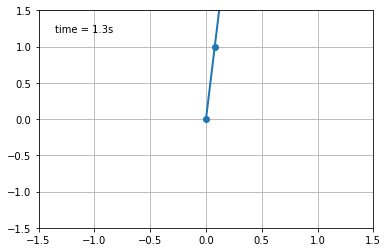

In [19]:
y = path_arr  #(n,4)
x1 = l1*sin(y[:, 0])
y1 = l1*cos(y[:, 0])

x2 = x1 - l2*sin(y[:,1]-y[:,0])
y2 = l2*cos(y[:,1]-y[:,0]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    dt = 0.02
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=25, blit=True, init_func=init)

# uncomment this if want to see animation

# ani.save('acrobot_state_30_u_3.mp4', fps=15)
rc('animation', html='jshtml')
ani

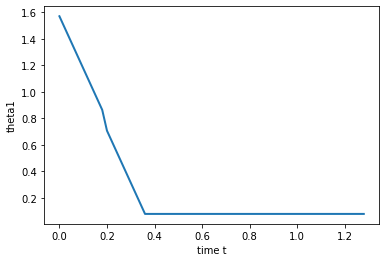

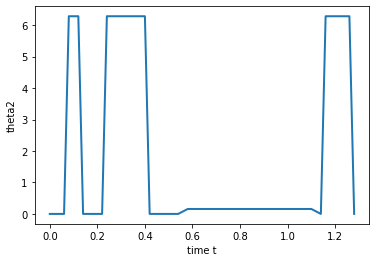

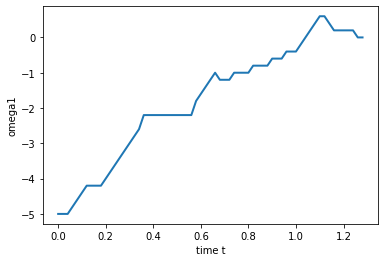

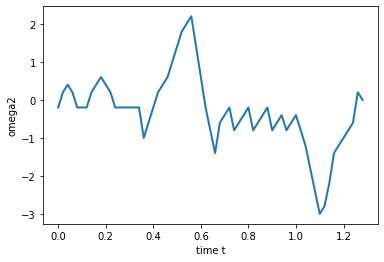

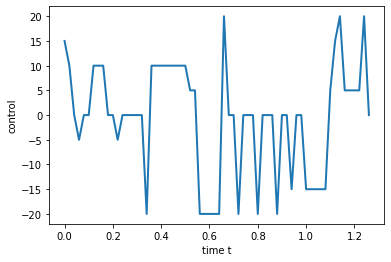

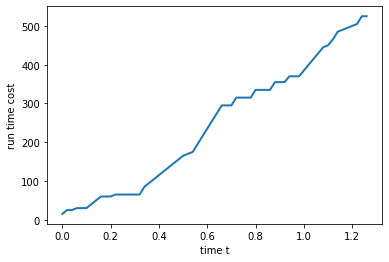

In [17]:
# plots
t_control = T[0:-1]
line1, = plt.plot(T,path_arr[:,0], label="theta1",linewidth=2)
plt.xlabel('time t')
plt.ylabel('theta1')
plt.show()
line2, = plt.plot(T,path_arr[:,1], label="theta2",linewidth=2)
plt.xlabel('time t')
plt.ylabel('theta2')
plt.show()
line3, = plt.plot(T,path_arr[:,2], label="omega1",linewidth=2)
plt.xlabel('time t')
plt.ylabel('omega1')
plt.show()
line4, = plt.plot(T,path_arr[:,3], label="omega2",linewidth=2)
plt.xlabel('time t')
plt.ylabel('omega2')
plt.show()
line5, = plt.plot(t_control,controls, label="control",linewidth=2)
plt.xlabel('time t')
plt.ylabel('control')
plt.show()
line6, = plt.plot(t_control,run_time_cost, label="run time cost",linewidth=2)
plt.xlabel('time t')
plt.ylabel('run time cost')
plt.show()